In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rdkit-pypi
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

import shap

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

from joblib import dump
from joblib import load


**SECOND STUDY : This study follows on from the previous one, which only included combinations with a PCE above 15. This dataset has been augmented by another containing around 1000 lines with varying PCE values.**

# DATA CONSTRUCTION

This involves generating descriptors for each type of molecule (acceptor, donor).

## FOR DONNORS

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/M1_OSCML_PROJECT_2025/M12024_DATA_augmented.csv")


In [ ]:
data

,Mol_don,Mol_acc,PCE,Voc,Jsc,FF,SMILES_acc,SMILES_don,DOI
0,D18,S9TBO-F,17.17,0.838,28.19,0.749,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089
1,D18,BS3TSe-4F,18.48,0.828,29.40,0.759,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089
2,PM6,Y-BO-FCl,17.52,0.850,23.45,0.779,CCCCCCC(CCCC)CN7c3c(sc4c([C11])c(C=c2c(=O)c1cc...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1039/d1ee01832a
3,PM6,Y-BO-FBr,16.47,0.850,25.83,0.750,CCCCCCC(CCCC)Cn%12c4c3sc(C=c2c(=O)c1cc(Br)c(F)...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1039/d1ee01832a
4,PM6,PY-V-y,17.1,0.912,24.80,0.758,CC(C)(C)/C=C/c%12ccc%11c(=C(C#N)C#N)c(=Cc%10sc...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1002/adma.202200361
...,...,...,...,...,...,...,...,...,...
1120,PBDB-T-2Cl,ICPDT-4F,5.39,0.880,9.96,61.400,CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5c(c32)...,CCc1sc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c9...,10.1021/acs.jpcc.0c09663
1121,PBDB-T,ICPDT-4F,9.8,0.780,19.87,63.300,CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5c(c32)...,CCc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c...,10.1021/acs.jpcc.0c09663
1122,PBDB-T,IBR,6.66,1.160,9.46,60.710,CCN1C(=O)/C(=C\c2ccc(-c3ccc4c(c3)C(CC)(CC)C3=C...,CCc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c...,10.1016/j.dyepig.2019.02.017
1123,PTB7-Th,ITIC,8.79,0.840,15.43,68.000,CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5cc(/C=...,CCOC(=O)c1sc2c(-c3cc4c(-c5ccc(CC)s5)c5sc(-c6sc...,10.1002/adma.201702547


In [ ]:
def canonical_smiles(smiles):
    canonical_smiles_list = []
    for smi in smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            canonical_smiles_list.append(Chem.MolToSmiles(mol))
        else:
            print(f"Invalid SMILES: {smi}")
            canonical_smiles_list.append(None)
    return canonical_smiles_list




In [ ]:
# Function call
Canon_SMILES_don = canonical_smiles(data['SMILES_don'])

[17:24:24] SMILES Parse Error: syntax error while parsing: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5
[17:24:24] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5' for input: 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5'
[17:24:24] SMILES Parse Error: syntax error while parsing: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5
[17:24:24] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5' for input: 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5'


Invalid SMILES: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5
Invalid SMILES: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5


In [ ]:
data['TEMP_SMILES'] = Canon_SMILES_don

In [ ]:
def RDkit_descriptors(smiles):
    mols = []
    invalid_smiles = []
    indices = []  # List to store the index of each SMILES string
    for idx, i in enumerate(smiles):  # enumerate to get both index and value
        if pd.notna(i):  # Check if SMILES is not NaN
            mol = Chem.MolFromSmiles(i)
            if mol is None:
                print(f"Id {idx} Invalid SMILES: {i}")
                invalid_smiles.append(i)
            else:
                mols.append(mol)
                indices.append(idx)  # Store the index for valid SMILES

    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in mols:
        mol=Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)

    return Mol_descriptors, desc_names, invalid_smiles, indices



In [ ]:

Mol_descriptors_don, desc_names_don, invalid_smiles_don, indices_don = RDkit_descriptors(data['SMILES_don'])

descriptor_df_don = pd.DataFrame(Mol_descriptors_don, columns=desc_names_don, index=indices_don)



[17:24:34] SMILES Parse Error: syntax error while parsing: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5
[17:24:34] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5' for input: 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5'
[17:24:34] SMILES Parse Error: syntax error while parsing: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5
[17:24:34] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5' for input: 'CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5'


Id 9 Invalid SMILES: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5
Id 10 Invalid SMILES: CCCCCCCCCCC(CCCCCCCC)CCc3cc(c2sc(c1cc(CC(CCCCCCCC)CCCCCCCCCC)c([]n]C)s1)cc2C#N)sc3c5cc(F)c(c4sc([[]C)cc4F)s5


In [ ]:
descriptor_df_don

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,18.953056,-6.348990,18.953056,0.007572,0.039440,1345.149,1249.389,1343.525974,476,0,...,0,0,0,0,0,0,0,7,0,0
1,18.953056,-6.348990,18.953056,0.007572,0.039440,1345.149,1249.389,1343.525974,476,0,...,0,0,0,0,0,0,0,7,0,0
2,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
3,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
4,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,17.412948,-4.100178,17.412948,0.029058,0.046275,2750.460,2663.772,2743.785261,836,0,...,0,0,0,0,0,0,0,24,0,0
1121,17.396252,-4.112128,17.396252,0.005478,0.046275,2543.790,2451.054,2540.019095,800,0,...,0,0,0,0,0,0,0,24,0,0
1122,17.396252,-4.112128,17.396252,0.005478,0.046275,2543.790,2451.054,2540.019095,800,0,...,0,0,0,0,0,0,0,24,0,0
1123,19.645424,-4.137465,19.645424,0.031704,0.046899,1912.737,1847.217,1909.970602,602,0,...,0,0,0,0,0,0,0,18,0,0


In [ ]:
df_with_200_descriptors_don = descriptor_df_don.add_prefix('don_')

In [ ]:
df_with_200_descriptors_don

,don_MaxEStateIndex,don_MinEStateIndex,don_MaxAbsEStateIndex,don_MinAbsEStateIndex,don_qed,don_MolWt,don_HeavyAtomMolWt,don_ExactMolWt,don_NumValenceElectrons,don_NumRadicalElectrons,...,don_fr_sulfide,don_fr_sulfonamd,don_fr_sulfone,don_fr_term_acetylene,don_fr_tetrazole,don_fr_thiazole,don_fr_thiocyan,don_fr_thiophene,don_fr_unbrch_alkane,don_fr_urea
0,18.953056,-6.348990,18.953056,0.007572,0.039440,1345.149,1249.389,1343.525974,476,0,...,0,0,0,0,0,0,0,7,0,0
1,18.953056,-6.348990,18.953056,0.007572,0.039440,1345.149,1249.389,1343.525974,476,0,...,0,0,0,0,0,0,0,7,0,0
2,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
3,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
4,18.378842,-5.822245,18.378842,0.087292,0.046822,1221.902,1143.278,1220.373556,424,0,...,0,0,0,0,0,0,0,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,17.412948,-4.100178,17.412948,0.029058,0.046275,2750.460,2663.772,2743.785261,836,0,...,0,0,0,0,0,0,0,24,0,0
1121,17.396252,-4.112128,17.396252,0.005478,0.046275,2543.790,2451.054,2540.019095,800,0,...,0,0,0,0,0,0,0,24,0,0
1122,17.396252,-4.112128,17.396252,0.005478,0.046275,2543.790,2451.054,2540.019095,800,0,...,0,0,0,0,0,0,0,24,0,0
1123,19.645424,-4.137465,19.645424,0.031704,0.046899,1912.737,1847.217,1909.970602,602,0,...,0,0,0,0,0,0,0,18,0,0


In [ ]:
df_with_200_descriptors_don = pd.merge(data, df_with_200_descriptors_don, left_index=True, right_index=True)

In [ ]:
df_with_200_descriptors_don

,Mol_don,Mol_acc,PCE,Voc,Jsc,FF,SMILES_acc,SMILES_don,DOI,TEMP_SMILES,...,don_fr_sulfide,don_fr_sulfonamd,don_fr_sulfone,don_fr_term_acetylene,don_fr_tetrazole,don_fr_thiazole,don_fr_thiocyan,don_fr_thiophene,don_fr_unbrch_alkane,don_fr_urea
0,D18,S9TBO-F,17.17,0.838,28.19,0.749,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089,CCCCCCC(CCCC)Cc1csc(-c2cc3c4nsnc4c4cc(-c5cc(CC...,...,0,0,0,0,0,0,0,7,0,0
1,D18,BS3TSe-4F,18.48,0.828,29.40,0.759,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089,CCCCCCC(CCCC)Cc1csc(-c2cc3c4nsnc4c4cc(-c5cc(CC...,...,0,0,0,0,0,0,0,7,0,0
2,PM6,Y-BO-FCl,17.52,0.850,23.45,0.779,CCCCCCC(CCCC)CN7c3c(sc4c([C11])c(C=c2c(=O)c1cc...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1039/d1ee01832a,CCCCC(CC)Cc1sc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c...,...,0,0,0,0,0,0,0,8,0,0
3,PM6,Y-BO-FBr,16.47,0.850,25.83,0.750,CCCCCCC(CCCC)Cn%12c4c3sc(C=c2c(=O)c1cc(Br)c(F)...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1039/d1ee01832a,CCCCC(CC)Cc1sc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c...,...,0,0,0,0,0,0,0,8,0,0
4,PM6,PY-V-y,17.1,0.912,24.80,0.758,CC(C)(C)/C=C/c%12ccc%11c(=C(C#N)C#N)c(=Cc%10sc...,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1002/adma.202200361,CCCCC(CC)Cc1sc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c...,...,0,0,0,0,0,0,0,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,PBDB-T-2Cl,ICPDT-4F,5.39,0.880,9.96,61.400,CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5c(c32)...,CCc1sc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c9...,10.1021/acs.jpcc.0c09663,CCc1sc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c9...,...,0,0,0,0,0,0,0,24,0,0
1121,PBDB-T,ICPDT-4F,9.8,0.780,19.87,63.300,CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5c(c32)...,CCc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c...,10.1021/acs.jpcc.0c09663,CCc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c...,...,0,0,0,0,0,0,0,24,0,0
1122,PBDB-T,IBR,6.66,1.160,9.46,60.710,CCN1C(=O)/C(=C\c2ccc(-c3ccc4c(c3)C(CC)(CC)C3=C...,CCc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c...,10.1016/j.dyepig.2019.02.017,CCc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c...,...,0,0,0,0,0,0,0,24,0,0
1123,PTB7-Th,ITIC,8.79,0.840,15.43,68.000,CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5cc(/C=...,CCOC(=O)c1sc2c(-c3cc4c(-c5ccc(CC)s5)c5sc(-c6sc...,10.1002/adma.201702547,CCOC(=O)c1sc2c(-c3cc4c(-c5ccc(CC)s5)c5sc(-c6sc...,...,0,0,0,0,0,0,0,18,0,0


## For Acceptors

In [ ]:
Canon_SMILES_acc = canonical_smiles(df_with_200_descriptors_don['SMILES_acc'])
df_with_200_descriptors_don['TEMP_SMILES'] = Canon_SMILES_acc

[17:39:48] SMILES Parse Error: syntax error while parsing: CCCCCCC(CCCC)CN7c3c(sc4c([C11])c(C=c2c(=O)c1cc(Br)c(F)cc1c2=C([CN])[CN])sc34)C6c5nsnc5c8c(C67)n(CC(CCCC)CCCCCC)c%12c8sc%11c([C11])c(C(C)C/%10C(=O)c9cc(Br)c(F)cc9C%10=C([CN])\[CN])sc%11%12
[17:39:48] SMILES Parse Error: Failed parsing SMILES 'CCCCCCC(CCCC)CN7c3c(sc4c([C11])c(C=c2c(=O)c1cc(Br)c(F)cc1c2=C([CN])[CN])sc34)C6c5nsnc5c8c(C67)n(CC(CCCC)CCCCCC)c%12c8sc%11c([C11])c(C(C)C/%10C(=O)c9cc(Br)c(F)cc9C%10=C([CN])\[CN])sc%11%12' for input: 'CCCCCCC(CCCC)CN7c3c(sc4c([C11])c(C=c2c(=O)c1cc(Br)c(F)cc1c2=C([CN])[CN])sc34)C6c5nsnc5c8c(C67)n(CC(CCCC)CCCCCC)c%12c8sc%11c([C11])c(C(C)C/%10C(=O)c9cc(Br)c(F)cc9C%10=C([CN])\[CN])sc%11%12'
[17:39:48] SMILES Parse Error: syntax error while parsing: CCCCCCC(CCCC)Cn%12c4c3sc(C=c2c(=O)c1cc(Br)c(F)cc1c2=C(C#N)C#N)c([C11])c3sc4c%11c5nsnc5c%10c9sc8c([C11])c(C=c7c(=O)c6cc(Br)c(F)cc6c7=C(C#N)C#N)sc8c9n(CC(CCCC)CCCCCC)c%10c%11%12
[17:39:48] SMILES Parse Error: Failed parsing SMILES 'CCCCCCC(CCCC)Cn%12c4

Invalid SMILES: CCCCCCC(CCCC)CN7c3c(sc4c([C11])c(C=c2c(=O)c1cc(Br)c(F)cc1c2=C([CN])[CN])sc34)C6c5nsnc5c8c(C67)n(CC(CCCC)CCCCCC)c%12c8sc%11c([C11])c(C(C)C/%10C(=O)c9cc(Br)c(F)cc9C%10=C([CN])\[CN])sc%11%12
Invalid SMILES: CCCCCCC(CCCC)Cn%12c4c3sc(C=c2c(=O)c1cc(Br)c(F)cc1c2=C(C#N)C#N)c([C11])c3sc4c%11c5nsnc5c%10c9sc8c([C11])c(C=c7c(=O)c6cc(Br)c(F)cc6c7=C(C#N)C#N)sc8c9n(CC(CCCC)CCCCCC)c%10c%11%12
Invalid SMILES: CC(C)(C)/C=C/c%12ccc%11c(=C(C#N)C#N)c(=Cc%10sc8c(sc9c7c1nsnc1c6c5sc4c([C11])c(C=c3c(=O)c2cc(C(C)(C)C)ccc2c3=C(C#N)C#N)sc4c5n(CC([C8])[C10])c6c7n(CC([C8])[C10])c89)c%10[C11])c(=O)c%11c%12
Invalid SMILES: CC(C)(C)c%14ccc%13c(=C(C#N)C#N)c(=Cc%12sc%10c(sc%11c9c1nsnc1c8c7sc6c([C11])c(C=c5c(=O)c4cc(c3ccc(c2ccc(C(C)(C)C)s2)s3)ccc4c5=C(C#N)C#N)sc6c7n(CC([C8])[C10])c8c9n(CC([C8])[C10])c%10%11)c%12[C11])c(=O)c%13c%14
Invalid SMILES: CCCCCCC(CCCC)Cn%13c4c3sc(C=c2c(=O)c1cc(Cl)c(Cl)cc1c2=C(C#N)C#N)c([C11])c3sc4c%12c5nsnc5c%11c%10sc9c([C11])c(C=c8c(=O)c7cc6sc(Cl)cc6cc7c8=C(C#N)C#N)sc9c%10n(CC(CC

[17:39:49] SMILES Parse Error: syntax error while parsing: c1c(c(cc2c1C(=C(C#N)C#N)/C(=C/c1sc3c(c1CCCCCCCCCCC)sc1c3nh(c3c1c1c(c4c3n(c3c4sc4c3s/c(=C\C3=C(c5c(C3=O)cc(c(c
[17:39:49] SMILES Parse Error: Failed parsing SMILES 'c1c(c(cc2c1C(=C(C#N)C#N)/C(=C/c1sc3c(c1CCCCCCCCCCC)sc1c3nh(c3c1c1c(c4c3n(c3c4sc4c3s/c(=C\C3=C(c5c(C3=O)cc(c(c' for input: 'c1c(c(cc2c1C(=C(C#N)C#N)/C(=C/c1sc3c(c1CCCCCCCCCCC)sc1c3nh(c3c1c1c(c4c3n(c3c4sc4c3s/c(=C\C3=C(c5c(C3=O)cc(c(c'
[17:39:49] SMILES Parse Error: syntax error while parsing: c1c(c(cc2c1C(=C(C#N)C#N)/C(=C/c1sc3c(c1CCCCCCCCCCC)sc1c3nh(c3c1c1c(c4c3n(c3c4sc4c3s/c(=C\C3=C(c5c(C3=O)cc(c(c
[17:39:49] SMILES Parse Error: Failed parsing SMILES 'c1c(c(cc2c1C(=C(C#N)C#N)/C(=C/c1sc3c(c1CCCCCCCCCCC)sc1c3nh(c3c1c1c(c4c3n(c3c4sc4c3s/c(=C\C3=C(c5c(C3=O)cc(c(c' for input: 'c1c(c(cc2c1C(=C(C#N)C#N)/C(=C/c1sc3c(c1CCCCCCCCCCC)sc1c3nh(c3c1c1c(c4c3n(c3c4sc4c3s/c(=C\C3=C(c5c(C3=O)cc(c(c'
[17:39:49] SMILES Parse Error: extra open parentheses for input: 'c1c(c(cc2c1C(=C(C#N)

Invalid SMILES: c1c(c(cc2c1C(=C(C#N)C#N)/C(=C/c1sc3c(c1CCCCCCCCCCC)sc1c3nh(c3c1c1c(c4c3n(c3c4sc4c3s/c(=C\C3=C(c5c(C3=O)cc(c(c 5)F)F)[C](C#N)C#N)/c4CCCCCCCCCCC)C[C@@H](CCCCC C)CCCC)ns[n]1)C[C@H](CCCC)CCCCCC)/C2=O)F)F
Invalid SMILES: c1c(c(cc2c1C(=C(C#N)C#N)/C(=C/c1sc3c(c1CCCCCCCCCCC)sc1c3nh(c3c1c1c(c4c3n(c3c4sc4c3s/c(=C\C3=C(c5c(C3=O)cc(c(c 5)F)F)[C](C#N)C#N)/c4CCCCCCCCCCC)C[C@@H](CCCCC C)CCCC)ns[n]1)C[C@H](CCCC)CCCCCC)/C2=O)F)F
Invalid SMILES: c1c(c(cc2c1C(=C(C#N)C#N)/C(=C/c1sc3c(c1CCCCCCCCCCC)sc1c3n(c3c1c1c(c4c3n(c3c4sc4=C([C](Sc34)/C=C/3\C(=O)c4c(C3=C(C#N)C#N)cc(c(c4)Cl)Cl)CCCCCCCCCCC)C[C@@H](CC CCCC)CCCC)ns[n]1)C[C@H](CCCC)CCCCCC)/C2=O)Cl)Cl
Invalid SMILES: c1c(c(cc2c1C(=C(C#N)C#N)/C(=C/c1sc3c(c1CCCCCCCCC)sc1c3n(c3c1c1c(c4c3n(c3c4sc4c3s/c(=C\C3=C(c5c(C3=O)cc(c(c5)Cl)Cl)[C](C#N)C#N)/c4CCCCCCCCC)C[C@@H](CCCCCC)CCCC)ns[n]1)C[C@H](CCCC)CCCCCC)/C2=O)Cl)Cl
Invalid SMILES: CCCCCCC(CCCC)CN9/C4=C(SC5/C([C11])=C(C=c3c(=O)c2CC\1/C=C(F)\C(F)=C/C1=C/c2c3=C(C#N)C#N)\SC45)\C8c6nsnc6c7c(S)c(C)n(CC(

[17:39:50] SMILES Parse Error: syntax error while parsing: bad
[17:39:50] SMILES Parse Error: Failed parsing SMILES 'bad' for input: 'bad'


Invalid SMILES: bad mol


In [ ]:
Mol_descriptors_acc, desc_names_acc, invalid_smiles_acc, indices_acc = RDkit_descriptors(df_with_200_descriptors_don['TEMP_SMILES'])

descriptor_df_acc = pd.DataFrame(Mol_descriptors_acc, columns=desc_names_acc, index=indices_acc)

In [ ]:
df_with_200_descriptors_acc = descriptor_df_acc.add_prefix('acc_')

In [ ]:
data_with_descriptors = pd.merge(df_with_200_descriptors_don, df_with_200_descriptors_acc,left_index=True, right_index=True).drop(columns=["TEMP_SMILES"])

In [ ]:
data_with_descriptors

,Mol_don,Mol_acc,PCE,Voc,Jsc,FF,SMILES_acc,SMILES_don,DOI,don_MaxEStateIndex,...,acc_fr_sulfide,acc_fr_sulfonamd,acc_fr_sulfone,acc_fr_term_acetylene,acc_fr_tetrazole,acc_fr_thiazole,acc_fr_thiocyan,acc_fr_thiophene,acc_fr_unbrch_alkane,acc_fr_urea
0,D18,S9TBO-F,17.17,0.838,28.19,0.749,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089,18.953056,...,0,0,0,0,0,0,0,4,0,0
1,D18,BS3TSe-4F,18.48,0.828,29.40,0.759,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089,18.953056,...,0,0,0,0,0,0,0,3,0,0
6,PBDTT1Cl,Y18-1F,17.1,0.870,27.70,0.713,CCCCCCCCc3c(C=c2c(=O)c1cc*(F)ccc1c2=C(C#N)C#N)...,CCCCC(CC)Cc%12ccc(c%10c2cc(c1sc(C(C)(C)C)cc1Cl...,10.1002/adma.20215483,11.059775,...,0,0,0,0,0,0,0,4,0,0
11,D18,L8-BO,19.05,0.900,24.55,0.758,CCc1sc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c9...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202204718,18.953056,...,0,0,0,0,0,0,0,24,0,0
12,PM6,CH4,16.49,0.888,26.11,0.711,C,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1002/anie.202209580,18.378842,...,0,0,0,0,0,0,0,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,FTAZ,IOIC2,12.3,0.900,19.70,69.300,CCc1ccc(C2(c3ccc(CC)cc3)c3cc(/C=C4\C(=O)c5cc(F...,CCc1c2cc(-c3ccc(-c4c(F)c(F)c(-c5ccc(-c6cc7c(CC...,10.1002/adma.201704713,18.731697,...,0,0,0,0,0,0,0,4,0,0
1119,PBDB-T-4Cl,ICPDT-4F,1.04,0.910,2.36,48.400,CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5c(c32)...,CCc1sc(-c2c3cc(-c4sc(-c5sc(-c6cc(Cl)c(-c7cc8c(...,10.1021/acs.jpcc.0c09663,17.446595,...,0,0,0,0,0,0,0,4,0,0
1120,PBDB-T-2Cl,ICPDT-4F,5.39,0.880,9.96,61.400,CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5c(c32)...,CCc1sc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c9...,10.1021/acs.jpcc.0c09663,17.412948,...,2,0,0,0,0,0,0,0,0,0
1121,PBDB-T,ICPDT-4F,9.8,0.780,19.87,63.300,CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5c(c32)...,CCc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c...,10.1021/acs.jpcc.0c09663,17.396252,...,0,0,0,0,0,0,0,4,0,0


In [ ]:
data_with_descriptors.to_csv('/content/drive/MyDrive/M1_OSCML_PROJECT_2025/STUDY2_M12024_DATA.csv', index=False)

# DATA PREPROCESSING

In [ ]:
data_with_descriptors = pd.read_csv('/content/drive/MyDrive/M1_OSCML_PROJECT_2025/STUDY2_M12024_DATA.csv')

## General Information

In [ ]:
data_with_descriptors

,Mol_don,Mol_acc,PCE,Voc,Jsc,FF,SMILES_acc,SMILES_don,DOI,don_MaxEStateIndex,...,acc_fr_sulfide,acc_fr_sulfonamd,acc_fr_sulfone,acc_fr_term_acetylene,acc_fr_tetrazole,acc_fr_thiazole,acc_fr_thiocyan,acc_fr_thiophene,acc_fr_unbrch_alkane,acc_fr_urea
0,D18,S9TBO-F,17.17,0.838,28.19,0.749,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089,18.953056,...,0,0,0,0,0,0,0,4,0,0
1,D18,BS3TSe-4F,18.48,0.828,29.40,0.759,CCCCCCCCCc3c(C=c2c(=O)c1cc(F)c(F)cc1c2=C(C#N)C...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202202089,18.953056,...,0,0,0,0,0,0,0,3,0,0
2,PBDTT1Cl,Y18-1F,17.1,0.870,27.70,0.713,CCCCCCCCc3c(C=c2c(=O)c1cc*(F)ccc1c2=C(C#N)C#N)...,CCCCC(CC)Cc%12ccc(c%10c2cc(c1sc(C(C)(C)C)cc1Cl...,10.1002/adma.20215483,11.059775,...,0,0,0,0,0,0,0,4,0,0
3,D18,L8-BO,19.05,0.900,24.55,0.758,CCc1sc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c9...,CCCCCCC(CC1=CSC(C2=CC3=C(C4=C(C5=NSN=C53)C=C(S...,10.1002/adma.202204718,18.953056,...,0,0,0,0,0,0,0,24,0,0
4,PM6,CH4,16.49,0.888,26.11,0.711,C,FC1=C(CC(CCCC)CC)SC(C2=C(C=C(C3=CC=C(C4=C5C(C(...,10.1002/anie.202209580,18.378842,...,0,0,0,0,0,0,0,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,FTAZ,IOIC2,12.3,0.900,19.70,69.300,CCc1ccc(C2(c3ccc(CC)cc3)c3cc(/C=C4\C(=O)c5cc(F...,CCc1c2cc(-c3ccc(-c4c(F)c(F)c(-c5ccc(-c6cc7c(CC...,10.1002/adma.201704713,18.731697,...,0,0,0,0,0,0,0,4,0,0
1100,PBDB-T-4Cl,ICPDT-4F,1.04,0.910,2.36,48.400,CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5c(c32)...,CCc1sc(-c2c3cc(-c4sc(-c5sc(-c6cc(Cl)c(-c7cc8c(...,10.1021/acs.jpcc.0c09663,17.446595,...,0,0,0,0,0,0,0,4,0,0
1101,PBDB-T-2Cl,ICPDT-4F,5.39,0.880,9.96,61.400,CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5c(c32)...,CCc1sc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c9...,10.1021/acs.jpcc.0c09663,17.412948,...,2,0,0,0,0,0,0,0,0,0
1102,PBDB-T,ICPDT-4F,9.8,0.780,19.87,63.300,CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5c(c32)...,CCc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6ccc(-c7cc8c(-c...,10.1021/acs.jpcc.0c09663,17.396252,...,0,0,0,0,0,0,0,4,0,0


In [ ]:
data_with_descriptors = data_with_descriptors.drop(columns=["Voc","Jsc","FF"])

In [ ]:
data_with_descriptors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Columns: 422 entries, Mol_don to acc_fr_urea
dtypes: float64(208), int64(208), object(6)
memory usage: 3.6+ MB


In [ ]:
print(data_with_descriptors.dtypes)

Mol_don                 object
Mol_acc                 object
PCE                     object
SMILES_acc              object
SMILES_don              object
                         ...  
acc_fr_thiazole          int64
acc_fr_thiocyan          int64
acc_fr_thiophene         int64
acc_fr_unbrch_alkane     int64
acc_fr_urea              int64
Length: 422, dtype: object


In [ ]:
data_with_descriptors['PCE'] = data_with_descriptors['PCE'].str.replace(',', '.').astype(float)

In [ ]:
print(data_with_descriptors.dtypes)

Mol_don                  object
Mol_acc                  object
PCE                     float64
SMILES_acc               object
SMILES_don               object
                         ...   
acc_fr_thiazole           int64
acc_fr_thiocyan           int64
acc_fr_thiophene          int64
acc_fr_unbrch_alkane      int64
acc_fr_urea               int64
Length: 422, dtype: object


In [ ]:
data_with_descriptors.describe()

,PCE,don_MaxEStateIndex,don_MinEStateIndex,don_MaxAbsEStateIndex,don_MinAbsEStateIndex,don_qed,don_MolWt,don_HeavyAtomMolWt,don_ExactMolWt,don_NumValenceElectrons,...,acc_fr_sulfide,acc_fr_sulfonamd,acc_fr_sulfone,acc_fr_term_acetylene,acc_fr_tetrazole,acc_fr_thiazole,acc_fr_thiocyan,acc_fr_thiophene,acc_fr_unbrch_alkane,acc_fr_urea
count,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,...,1104.000000,1104.0,1104.0,1104.0,1104.0,1104.000000,1104.0,1104.000000,1104.0,1104.0
mean,10.168473,17.303617,-4.413959,17.303617,0.030554,0.055268,2137.550880,2058.177271,2134.399045,681.542572,...,0.119565,0.0,0.0,0.0,0.0,0.092391,0.0,4.163043,0.0,0.0
std,4.172792,2.764316,0.947774,2.764316,0.051549,0.035614,687.960026,669.179253,686.849631,211.225329,...,0.512949,0.0,0.0,0.0,0.0,0.445157,0.0,2.825004,0.0,0.0
min,0.010000,9.540220,-8.436932,9.540220,0.000048,0.015403,335.451000,310.251000,335.199762,130.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
25%,7.727500,17.396252,-4.152457,17.396252,0.005478,0.043289,1771.365000,1705.845000,1769.191564,584.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,3.000000,0.0,0.0
50%,10.400000,18.146414,-4.115510,18.146414,0.006157,0.046275,2543.790000,2451.054000,2540.019095,800.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,4.000000,0.0,0.0
75%,12.832500,18.731697,-4.090281,18.731697,0.031704,0.046899,2651.730000,2565.042000,2647.962564,836.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,4.000000,0.0,0.0
max,19.050000,21.476646,-3.594279,21.476646,0.544366,0.777618,3925.956000,3772.740000,3920.220849,1244.000000,...,4.000000,0.0,0.0,0.0,0.0,4.000000,0.0,24.000000,0.0,0.0


In [ ]:
num_unique_acceptors = data_with_descriptors['Mol_acc'].nunique()
num_unique_donors = data_with_descriptors['Mol_don'].nunique()

print("Number of unique acceptors:", num_unique_acceptors)
print("Number of unique donors:", num_unique_donors)

Number of unique acceptors: 694
Number of unique donors: 245


### Check for duplicated columns values

We need to identify the duplicate columns (values).

In [ ]:
def find_duplicate_columns(df):
    seen = set()
    duplicates = set()

    for column in df.columns:
        col_values = tuple(df[column])
        if col_values in seen:
            duplicates.add(column)
        else:
            seen.add(col_values)

    return duplicates

def remove_duplicate_columns(df):

    duplicates = find_duplicate_columns(df)
    df = df.drop(columns=duplicates)
    return df



In [ ]:
find_duplicate_columns(data_with_descriptors)


{'acc_MaxAbsEStateIndex',
 'acc_NumHDonors',
 'acc_NumRadicalElectrons',
 'acc_SMR_VSA8',
 'acc_SlogP_VSA9',
 'acc_fr_Al_COO',
 'acc_fr_Al_OH_noTert',
 'acc_fr_ArN',
 'acc_fr_Ar_COO',
 'acc_fr_Ar_NH',
 'acc_fr_COO',
 'acc_fr_COO2',
 'acc_fr_C_O_noCOO',
 'acc_fr_HOCCN',
 'acc_fr_NH1',
 'acc_fr_NH2',
 'acc_fr_N_O',
 'acc_fr_Nhpyrrole',
 'acc_fr_SH',
 'acc_fr_aldehyde',
 'acc_fr_alkyl_carbamate',
 'acc_fr_amidine',
 'acc_fr_azide',
 'acc_fr_azo',
 'acc_fr_barbitur',
 'acc_fr_benzodiazepine',
 'acc_fr_diazo',
 'acc_fr_dihydropyridine',
 'acc_fr_epoxide',
 'acc_fr_guanido',
 'acc_fr_hdrzine',
 'acc_fr_hdrzone',
 'acc_fr_imidazole',
 'acc_fr_isocyan',
 'acc_fr_isothiocyan',
 'acc_fr_lactam',
 'acc_fr_lactone',
 'acc_fr_morpholine',
 'acc_fr_nitro_arom',
 'acc_fr_nitro_arom_nonortho',
 'acc_fr_nitroso',
 'acc_fr_oxazole',
 'acc_fr_oxime',
 'acc_fr_phenol',
 'acc_fr_phenol_noOrthoHbond',
 'acc_fr_phos_acid',
 'acc_fr_phos_ester',
 'acc_fr_piperdine',
 'acc_fr_piperzine',
 'acc_fr_priamide',
 '

In [ ]:
data_with_descriptors = remove_duplicate_columns(data_with_descriptors)


In [ ]:
data_with_descriptors.shape

(1104, 300)

### Delete NaN values

we also decide to delete any line with at least one NaN value

In [ ]:
data_with_descriptors = data_with_descriptors.dropna()

In [ ]:
data_with_descriptors.shape

(1063, 300)

### Delete same couple

Here, we don't need to have lines dealing with the same comninaisons because we'll have the same smiles and therefore the same descriptors.


In [ ]:
data_with_descriptors = data_with_descriptors.drop_duplicates(subset=['Mol_acc', 'Mol_don'])


In [ ]:
data_with_descriptors.shape

(1008, 300)

### Delete constant columns

In [ ]:
constant_columns = [col for col in data_with_descriptors.columns if data_with_descriptors[col].nunique() == 1]
len(constant_columns)

1

In [ ]:
data_with_descriptors = data_with_descriptors.drop(columns=constant_columns)

### Check Final unique molecules numbers

In [ ]:
num_unique_acceptors = data_with_descriptors['Mol_acc'].nunique()
num_unique_donors = data_with_descriptors['Mol_don'].nunique()

print("Number of unique acceptors:", num_unique_acceptors)
print("Number of unique donors:", num_unique_donors)

Number of unique acceptors: 675
Number of unique donors: 235


### Delete Object Columns

In [ ]:
object_columns = data_with_descriptors.select_dtypes(include='object').columns
object_columns

Index(['Mol_don', 'Mol_acc', 'SMILES_acc', 'SMILES_don', 'DOI'], dtype='object')

In [ ]:
data_with_descriptors.drop(columns=object_columns, inplace=True)

In [ ]:
data_with_descriptors.shape

(1008, 294)

In [ ]:
data_with_descriptors.describe()

,PCE,don_MaxEStateIndex,don_MinEStateIndex,don_MinAbsEStateIndex,don_qed,don_MolWt,don_HeavyAtomMolWt,don_ExactMolWt,don_NumValenceElectrons,don_MaxPartialCharge,...,acc_fr_ketone,acc_fr_ketone_Topliss,acc_fr_methoxy,acc_fr_nitrile,acc_fr_nitro,acc_fr_para_hydroxylation,acc_fr_pyridine,acc_fr_sulfide,acc_fr_thiazole,acc_fr_thiophene
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,...,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000
mean,9.761178,17.225647,-4.407709,0.029870,0.055781,2124.024681,2044.893681,2120.861826,677.539683,0.207963,...,1.780754,1.725198,0.039683,3.655754,0.001984,0.007937,0.016865,0.128968,0.099206,4.191468
std,3.998916,2.849432,0.951046,0.048793,0.036561,693.899638,674.486123,692.748812,213.565751,0.072862,...,0.931916,0.860059,0.342913,1.494627,0.062994,0.154176,0.228794,0.532214,0.461076,2.848029
min,0.010000,9.540220,-8.436932,0.000048,0.015403,335.451000,310.251000,335.199762,130.000000,0.064158,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.422500,17.396252,-4.152457,0.005478,0.043289,1771.365000,1705.845000,1769.191564,578.000000,0.170047,...,2.000000,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,10.130000,17.600363,-4.112128,0.006157,0.046275,2543.790000,2451.054000,2540.019095,800.000000,0.196678,...,2.000000,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,12.300000,18.731697,-4.086935,0.031704,0.047072,2651.730000,2565.042000,2647.962564,836.000000,0.196678,...,2.000000,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
max,19.050000,21.476646,-3.594279,0.544366,0.777618,3925.956000,3772.740000,3920.220849,1244.000000,0.419484,...,6.000000,4.000000,4.000000,8.000000,2.000000,4.000000,4.000000,4.000000,4.000000,24.000000


### Delete too hight values (columns)

In [ ]:
threshold = 1e6

filtered_columns = data_with_descriptors.columns[(data_with_descriptors.std() <= threshold)]
data_with_descriptors = data_with_descriptors[filtered_columns]

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1007: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


## Multivariate statistics

The complexity of the data is such that we cannot simply have a bivariate visual between the variables. We therefore use data_profiling to simplify this task. This tool displays all the basic statistics and visualizations of the dataset provided

In [ ]:
#data_with_descriptors.to_csv('Profile_M12024_DATA_OVER_15_With_DESCRIPTORS.csv', index=False)

In [ ]:
"""profile = ProfileReport(
    data_with_descriptors,
    title="Profiling Report For D-NFA dataset with descriptors ",
    html={'style':{'full_width':True}}
)

profile.to_file(output_file = "data_with_descriptors-profile.html")"""

'profile = ProfileReport(\n    data_with_descriptors,\n    title="Profiling Report For D-NFA dataset with descriptors ",\n    html={\'style\':{\'full_width\':True}}\n)\n\nprofile.to_file(output_file = "data_with_descriptors-profile.html")'

# FEATURE ENGINEERING

## By correlation analysis

In [ ]:
data_with_descriptors.corr()

,PCE,don_MaxEStateIndex,don_MinEStateIndex,don_MinAbsEStateIndex,don_qed,don_MolWt,don_HeavyAtomMolWt,don_ExactMolWt,don_NumValenceElectrons,don_MaxPartialCharge,...,acc_fr_ketone,acc_fr_ketone_Topliss,acc_fr_methoxy,acc_fr_nitrile,acc_fr_nitro,acc_fr_para_hydroxylation,acc_fr_pyridine,acc_fr_sulfide,acc_fr_thiazole,acc_fr_thiophene
PCE,1.000000,0.350028,-0.279636,0.264521,-0.184387,0.132238,0.128423,0.132301,0.149240,0.108873,...,0.184982,0.109072,-0.053609,0.031722,-0.012466,-0.025271,-0.068423,-0.044072,-0.058920,0.162291
don_MaxEStateIndex,0.350028,1.000000,-0.241162,0.100435,-0.551607,0.541082,0.540924,0.541326,0.564264,0.492963,...,0.107122,0.112064,-0.006088,0.071716,0.001888,-0.061561,0.011127,-0.023521,-0.075336,0.007122
don_MinEStateIndex,-0.279636,-0.241162,1.000000,-0.589776,0.157811,-0.078921,-0.062438,-0.078978,-0.123126,0.079907,...,-0.047363,0.017357,0.034608,0.056466,0.009799,0.025149,-0.170533,-0.022420,0.038680,-0.046349
don_MinAbsEStateIndex,0.264521,0.100435,-0.589776,1.000000,0.163748,-0.269678,-0.277768,-0.269627,-0.234979,0.109130,...,0.039836,-0.040562,-0.052281,-0.087695,-0.015761,-0.017757,0.126486,-0.000361,-0.052825,0.089269
don_qed,-0.184387,-0.551607,0.157811,0.163748,1.000000,-0.664046,-0.661682,-0.664116,-0.670179,-0.290622,...,-0.098007,-0.137800,-0.000742,-0.111664,-0.008197,0.066764,-0.011965,-0.020485,0.060235,0.159508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
acc_fr_para_hydroxylation,-0.025271,-0.061561,0.025149,-0.017757,0.066764,-0.059256,-0.058843,-0.059306,-0.062259,-0.005972,...,-0.043170,-0.043448,-0.005963,-0.022608,-0.001623,1.000000,-0.003798,-0.012487,0.044791,-0.030603
acc_fr_pyridine,-0.068423,0.011127,-0.170533,0.126486,-0.011965,0.019185,0.016588,0.019216,0.026823,-0.030362,...,-0.131679,-0.137915,-0.008539,-0.168860,-0.002324,-0.003798,1.000000,-0.017880,-0.015876,-0.078112
acc_fr_sulfide,-0.044072,-0.023521,-0.022420,-0.000361,-0.020485,-0.017465,-0.018139,-0.017441,-0.017213,0.016874,...,-0.399435,-0.417139,0.058990,-0.513400,-0.007640,-0.012487,-0.017880,1.000000,-0.019816,-0.147337
acc_fr_thiazole,-0.058920,-0.075336,0.038680,-0.052825,0.060235,-0.047857,-0.047470,-0.047870,-0.050726,-0.074366,...,-0.337597,-0.351890,0.025323,0.049606,-0.006784,0.044791,-0.015876,-0.019816,1.000000,-0.090102


In [ ]:
corr_df = data_with_descriptors.corr().abs()
mask = np.triu(np.ones_like(corr_df,dtype=bool))
tri_df = corr_df.mask(mask)
to_drop = [c for c in tri_df.columns if any(tri_df[c]  > 0.95)]
print(to_drop)

['don_MolWt', 'don_HeavyAtomMolWt', 'don_ExactMolWt', 'don_NumValenceElectrons', 'don_MaxPartialCharge', 'don_MinPartialCharge', 'don_FpDensityMorgan1', 'don_FpDensityMorgan2', 'don_BCUT2D_CHGHI', 'don_BCUT2D_MRHI', 'don_BertzCT', 'don_Chi0', 'don_Chi0n', 'don_Chi0v', 'don_Chi1', 'don_Chi1n', 'don_Chi1v', 'don_Chi2n', 'don_Chi2v', 'don_Chi3n', 'don_Chi3v', 'don_Chi4n', 'don_Chi4v', 'don_Kappa1', 'don_Kappa2', 'don_Kappa3', 'don_LabuteASA', 'don_PEOE_VSA13', 'don_PEOE_VSA14', 'don_PEOE_VSA5', 'don_SMR_VSA10', 'don_SMR_VSA2', 'don_SMR_VSA3', 'don_SlogP_VSA12', 'don_SlogP_VSA8', 'don_EState_VSA1', 'don_EState_VSA5', 'don_VSA_EState1', 'don_VSA_EState2', 'don_HeavyAtomCount', 'don_NHOHCount', 'don_NumAliphaticCarbocycles', 'don_NumAromaticHeterocycles', 'don_NumAromaticRings', 'don_RingCount', 'don_MolLogP', 'don_fr_Ar_N', 'don_fr_piperdine', 'acc_MolWt', 'acc_HeavyAtomMolWt', 'acc_ExactMolWt', 'acc_NumValenceElectrons', 'acc_MaxPartialCharge', 'acc_MinPartialCharge', 'acc_FpDensityMorgan2

In [ ]:
data_with_descriptors = data_with_descriptors.drop(columns=to_drop)

In [ ]:
data_with_descriptors.shape

(1008, 214)

In [ ]:
data_with_descriptors

,PCE,don_MaxEStateIndex,don_MinEStateIndex,don_MinAbsEStateIndex,don_qed,don_MaxAbsPartialCharge,don_MinAbsPartialCharge,don_FpDensityMorgan3,don_BCUT2D_MWHI,don_BCUT2D_MWLOW,...,acc_fr_ketone,acc_fr_ketone_Topliss,acc_fr_methoxy,acc_fr_nitrile,acc_fr_nitro,acc_fr_para_hydroxylation,acc_fr_pyridine,acc_fr_sulfide,acc_fr_thiazole,acc_fr_thiophene
3,19.05,18.953056,-6.348990,0.007572,0.039440,0.355876,0.166304,1.741573,1.722912e-15,-0.249293,...,0,0,0,0,0,0,0,0,0,24
4,16.49,18.378842,-5.822245,0.087292,0.046822,0.288460,0.196678,1.450000,1.000525e+01,-0.249293,...,2,2,0,4,0,0,0,0,0,6
5,16.69,19.355365,-6.601649,0.544366,0.036338,0.421269,0.344631,1.484211,1.433785e-15,-0.249293,...,2,2,0,4,0,0,0,0,0,4
6,18.51,19.266880,-5.598209,0.206342,0.041946,0.242117,0.169975,1.359551,1.053455e+01,-0.249293,...,2,2,0,4,0,0,0,0,0,4
7,18.21,18.378842,-5.822245,0.087292,0.046822,0.288460,0.196678,1.450000,1.000525e+01,-0.249293,...,2,2,0,4,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,12.30,18.731697,-4.082160,0.008265,0.070615,0.202927,0.170047,0.760684,1.240461e+01,-0.249097,...,2,2,0,4,0,0,0,0,0,4
1100,1.04,17.446595,-4.080068,0.060240,0.046275,0.288460,0.196678,0.568966,1.314037e+01,-0.249097,...,2,2,0,4,0,0,0,0,0,4
1101,5.39,17.412948,-4.100178,0.029058,0.046275,0.288460,0.196678,0.589286,1.267931e+01,-0.249097,...,0,0,0,0,0,0,0,2,0,0
1102,9.80,17.396252,-4.112128,0.005478,0.046275,0.288460,0.196678,0.598765,1.223955e+01,-0.249097,...,2,2,0,4,0,0,0,0,0,4


In [ ]:
data_with_descriptors = data_with_descriptors.round(3)
data_with_descriptors

,PCE,don_MaxEStateIndex,don_MinEStateIndex,don_MinAbsEStateIndex,don_qed,don_MaxAbsPartialCharge,don_MinAbsPartialCharge,don_FpDensityMorgan3,don_BCUT2D_MWHI,don_BCUT2D_MWLOW,...,acc_fr_ketone,acc_fr_ketone_Topliss,acc_fr_methoxy,acc_fr_nitrile,acc_fr_nitro,acc_fr_para_hydroxylation,acc_fr_pyridine,acc_fr_sulfide,acc_fr_thiazole,acc_fr_thiophene
3,19.05,18.953,-6.349,0.008,0.039,0.356,0.166,1.742,0.000,-0.249,...,0,0,0,0,0,0,0,0,0,24
4,16.49,18.379,-5.822,0.087,0.047,0.288,0.197,1.450,10.005,-0.249,...,2,2,0,4,0,0,0,0,0,6
5,16.69,19.355,-6.602,0.544,0.036,0.421,0.345,1.484,0.000,-0.249,...,2,2,0,4,0,0,0,0,0,4
6,18.51,19.267,-5.598,0.206,0.042,0.242,0.170,1.360,10.535,-0.249,...,2,2,0,4,0,0,0,0,0,4
7,18.21,18.379,-5.822,0.087,0.047,0.288,0.197,1.450,10.005,-0.249,...,2,2,0,4,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,12.30,18.732,-4.082,0.008,0.071,0.203,0.170,0.761,12.405,-0.249,...,2,2,0,4,0,0,0,0,0,4
1100,1.04,17.447,-4.080,0.060,0.046,0.288,0.197,0.569,13.140,-0.249,...,2,2,0,4,0,0,0,0,0,4
1101,5.39,17.413,-4.100,0.029,0.046,0.288,0.197,0.589,12.679,-0.249,...,0,0,0,0,0,0,0,2,0,0
1102,9.80,17.396,-4.112,0.005,0.046,0.288,0.197,0.599,12.240,-0.249,...,2,2,0,4,0,0,0,0,0,4


## By SHAP (SHapley Additive exPlanations)

In [ ]:
cols = ['PCE']
X_forshap = data_with_descriptors.drop(columns=cols)
y_forshap = data_with_descriptors['PCE']

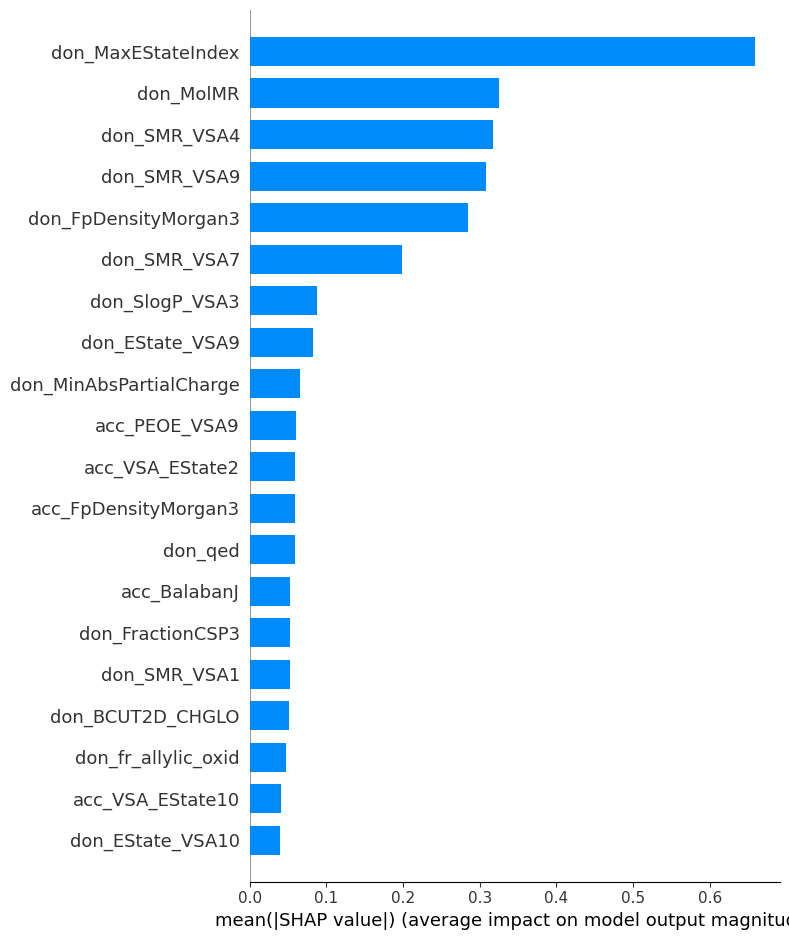

In [ ]:
#  With Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_forshap, y_forshap)

explainer = shap.Explainer(model)
shap_values_rf = explainer(X_forshap)

feature_importance_values = shap_values_rf.values
mean_shap_values = np.mean(np.abs(feature_importance_values), axis=0)
feature_names = X_forshap.columns
feature_importance_dict = dict(zip(feature_names, mean_shap_values))
rf_feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))


shap.summary_plot(shap_values_rf, X_forshap, plot_type='bar', show=False)

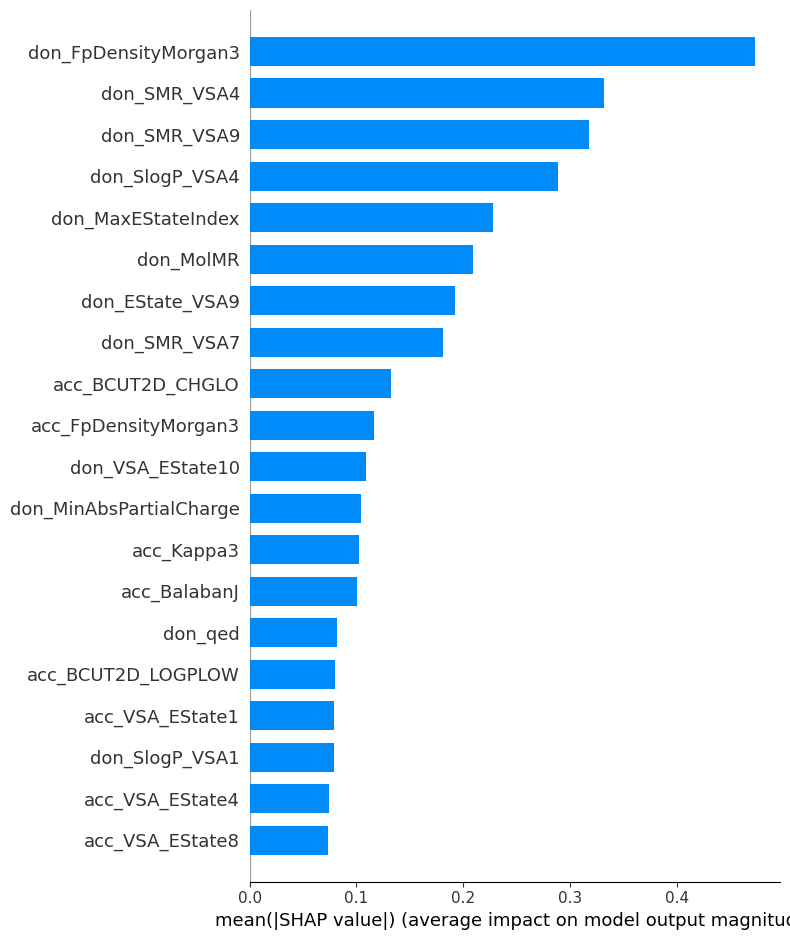

In [ ]:
# With Gradient Bossting
model = GradientBoostingRegressor(random_state=42)
model.fit(X_forshap, y_forshap)

explainer = shap.Explainer(model)
shap_values_gb = explainer(X_forshap)

feature_importance_values = shap_values_gb.values
mean_shap_values = np.mean(np.abs(feature_importance_values), axis=0)
feature_names = X_forshap.columns
feature_importance_dict = dict(zip(feature_names, mean_shap_values))
gb_feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

shap.summary_plot(shap_values_gb, X_forshap, plot_type='bar', show=False)


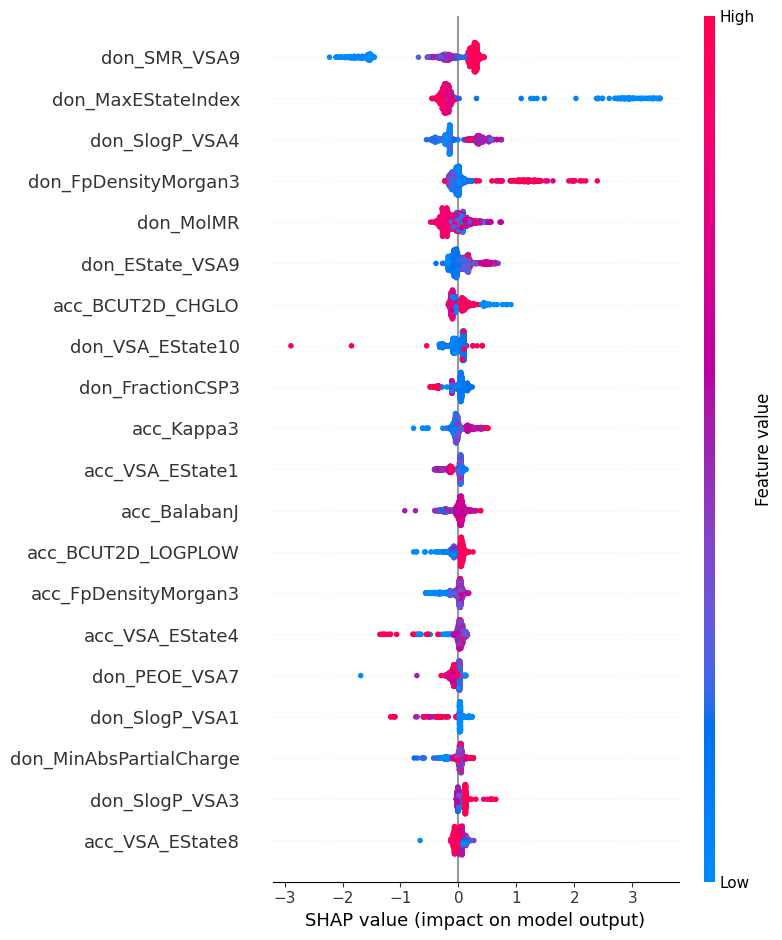

In [ ]:
feature_importance_diff = shap_values_gb - shap_values_rf
# Plot the difference
shap.summary_plot(feature_importance_diff, X_forshap, show=False)

we decide to rank features based on their importance derived from SHAP values and keep the top-ranked features

In [ ]:
mean_abs_shap_values = np.mean(np.abs(feature_importance_diff.values), axis=0)

# Rank features based on mean absolute SHAP values
ranked_features = sorted(zip(X_forshap.columns, mean_abs_shap_values), key=lambda x: x[1], reverse=True)

num_top_features = 15
top_features_to_keep = [feature for feature, _ in ranked_features[:num_top_features]]

print("Top-ranked features to keep:", top_features_to_keep)

Top-ranked features to keep: ['don_SMR_VSA9', 'don_MaxEStateIndex', 'don_SlogP_VSA4', 'don_FpDensityMorgan3', 'don_MolMR', 'don_EState_VSA9', 'acc_BCUT2D_CHGLO', 'don_VSA_EState10', 'don_FractionCSP3', 'acc_Kappa3', 'acc_VSA_EState1', 'acc_BalabanJ', 'acc_BCUT2D_LOGPLOW', 'acc_FpDensityMorgan3', 'acc_VSA_EState4']


# MODEL

In [ ]:
cols = ['PCE']
X = data_with_descriptors.drop(columns=cols)
y = data_with_descriptors['PCE']

Split data into train and test sets


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[top_features_to_keep], y, test_size=0.2, random_state=42)

In [ ]:
# data sent for study 1 for comparison purposes
test_data_to_send_for_Study1 = pd.DataFrame(X_test)
test_data_to_send_for_Study1['PCE'] = y_test

test_data_to_send_for_Study1.to_csv('/content/drive/MyDrive/M1_OSCML_PROJECT_2025/test_data_to_send_for_Study1.csv', index=False)

Standardize features

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Define and  Train models

In [ ]:
models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'XGBRegressor': XGBRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'ANN': MLPRegressor(max_iter=1000)
}


param_grids = {
    'DecisionTreeRegressor': {'max_depth': [3, 5, 7]},
    'GradientBoostingRegressor': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
    'XGBRegressor': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
    'RandomForestRegressor': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
    'ANN': {'hidden_layer_sizes': [(50,), (100,), (200,)], 'alpha': [0.0001, 0.001, 0.01]}
}



In [ ]:
np.random.seed(41)

model_names = []
train_r = []
test_r = []
train_mape = []
test_mape = []
train_rmse = []
test_rmse = []

for model_name, model in models.items():
    np.random.seed(41)
    print(f'Training {model_name}...')
    best_score = float('inf')
    best_params = None

    param_grid = param_grids[model_name]

    # Perform grid search without cross-validation
    for params in ParameterGrid(param_grid):
        model.set_params(**params)

        model.fit(X_train_scaled, y_train)
        y_test_pred = model.predict(X_test_scaled)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

        if rmse_test < best_score:
            best_score = rmse_test
            best_params = params

    print(best_params)
    model.set_params(**best_params)
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    r_train = np.corrcoef(y_train, y_train_pred)[0, 1]
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

    y_test_pred = model.predict(X_test_scaled)
    r_test = np.corrcoef(y_test, y_test_pred)[0, 1]
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    model_names.append(model_name)
    train_r.append(r_train)
    test_r.append(r_test)
    train_mape.append(mape_train)
    test_mape.append(mape_test)
    train_rmse.append(rmse_train)
    test_rmse.append(rmse_test)

    print(f'{model_name} - Training Pearson Correlation Coefficient (r): {r_train:.4f}')
    print(f'{model_name} - Training Mean Absolute Percentage Error (MAPE): {mape_train:.4f}')
    print(f'{model_name} - Training Root Mean Squared Error (RMSE): {rmse_train:.4f}')
    print(f'{model_name} - Testing Pearson Correlation Coefficient (r): {r_test:.4f}')
    print(f'{model_name} - Testing Mean Absolute Percentage Error (MAPE): {mape_test:.4f}')
    print(f'{model_name} - Testing Root Mean Squared Error (RMSE): {rmse_test:.4f}')
    print('\n')



Training DecisionTreeRegressor...
{'max_depth': 7}
DecisionTreeRegressor - Training Pearson Correlation Coefficient (r): 0.7941
DecisionTreeRegressor - Training Mean Absolute Percentage Error (MAPE): 0.8221
DecisionTreeRegressor - Training Root Mean Squared Error (RMSE): 2.4276
DecisionTreeRegressor - Testing Pearson Correlation Coefficient (r): 0.6166
DecisionTreeRegressor - Testing Mean Absolute Percentage Error (MAPE): 2.2512
DecisionTreeRegressor - Testing Root Mean Squared Error (RMSE): 3.2031


Training GradientBoostingRegressor...
{'max_depth': 3, 'n_estimators': 50}
GradientBoostingRegressor - Training Pearson Correlation Coefficient (r): 0.8116
GradientBoostingRegressor - Training Mean Absolute Percentage Error (MAPE): 1.6389
GradientBoostingRegressor - Training Root Mean Squared Error (RMSE): 2.3662
GradientBoostingRegressor - Testing Pearson Correlation Coefficient (r): 0.6250
GradientBoostingRegressor - Testing Mean Absolute Percentage Error (MAPE): 5.4943
GradientBoostingR

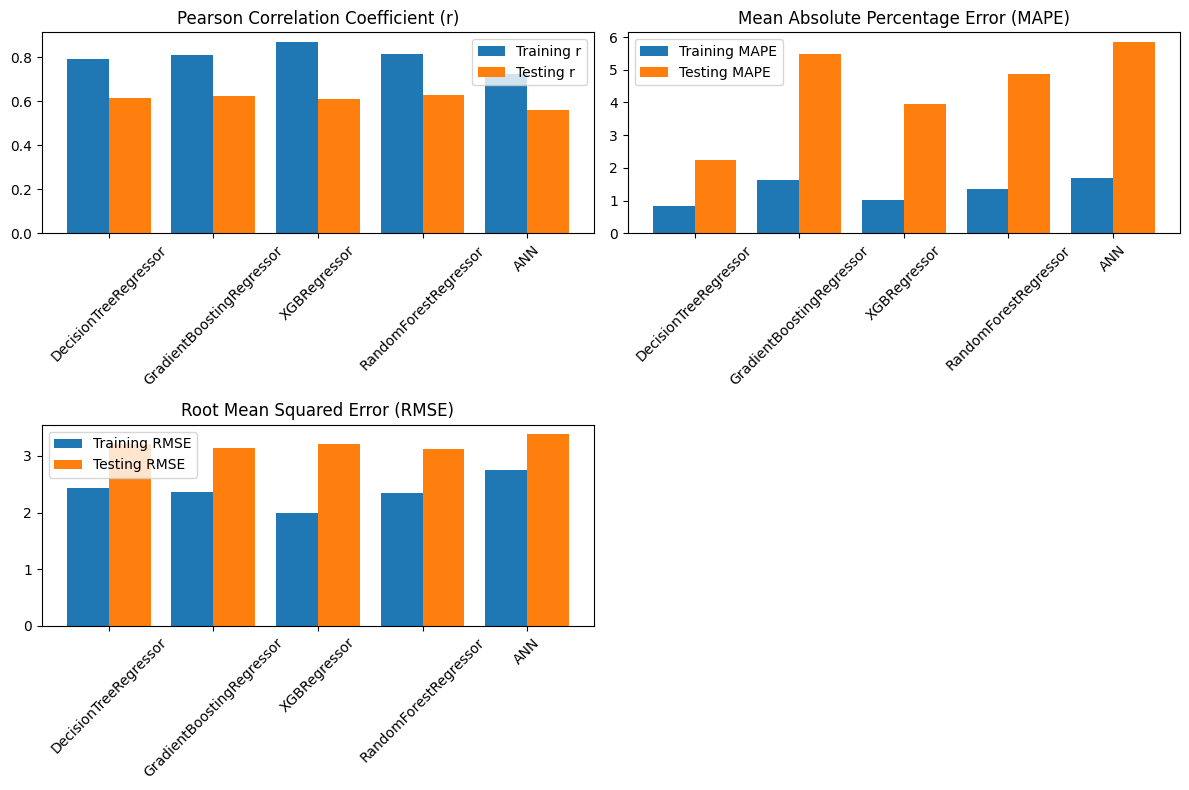

In [ ]:
plt.figure(figsize=(12, 8))

x = np.arange(len(model_names))

plt.subplot(2, 2, 1)
plt.bar(x - 0.2, train_r, width=0.4, label='Training r')
plt.bar(x + 0.2, test_r, width=0.4, label='Testing r')
plt.xticks(x, model_names, rotation=45)
plt.title('Pearson Correlation Coefficient (r)')
plt.legend()

plt.subplot(2, 2, 2)
plt.bar(x - 0.2, train_mape, width=0.4, label='Training MAPE')
plt.bar(x + 0.2, test_mape, width=0.4, label='Testing MAPE')
plt.xticks(x, model_names, rotation=45)
plt.title('Mean Absolute Percentage Error (MAPE)')
plt.legend()

plt.subplot(2, 2, 3)
plt.bar(x - 0.2, train_rmse, width=0.4, label='Training RMSE')
plt.bar(x + 0.2, test_rmse, width=0.4, label='Testing RMSE')
plt.xticks(x, model_names, rotation=45)
plt.title('Root Mean Squared Error (RMSE)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
"""np.random.seed(42)

model_names = []
train_r = []
test_r = []
train_mape = []
test_mape = []
train_rmse = []
test_rmse = []

train_r_std = []
test_r_std = []
train_mape_std = []
test_mape_std = []
train_rmse_std = []
test_rmse_std = []

num_iterations = 10

for model_name, model in models.items():
    np.random.seed(42)
    print(f'Training {model_name}...')

    train_r_iter = []
    test_r_iter = []
    train_mape_iter = []
    test_mape_iter = []
    train_rmse_iter = []
    test_rmse_iter = []

    for _ in range(num_iterations):
        for params in ParameterGrid(param_grids[model_name]):
            model.set_params(**params)
            model.fit(X_train_scaled, y_train)

            y_train_pred = model.predict(X_train_scaled)
            r_train = np.corrcoef(y_train, y_train_pred)[0, 1]
            mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
            rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
            train_r_iter.append(r_train)
            train_mape_iter.append(mape_train)
            train_rmse_iter.append(rmse_train)

            y_test_pred = model.predict(X_test_scaled)
            r_test = np.corrcoef(y_test, y_test_pred)[0, 1]
            mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
            rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
            test_r_iter.append(r_test)
            test_mape_iter.append(mape_test)
            test_rmse_iter.append(rmse_test)

    train_r_mean = np.mean(train_r_iter)
    test_r_mean = np.mean(test_r_iter)
    train_mape_mean = np.mean(train_mape_iter)
    test_mape_mean = np.mean(test_mape_iter)
    train_rmse_mean = np.mean(train_rmse_iter)
    test_rmse_mean = np.mean(test_rmse_iter)

    train_r_std.append(np.std(train_r_iter))
    test_r_std.append(np.std(test_r_iter))
    train_mape_std.append(np.std(train_mape_iter))
    test_mape_std.append(np.std(test_mape_iter))
    train_rmse_std.append(np.std(train_rmse_iter))
    test_rmse_std.append(np.std(test_rmse_iter))

    model_names.append(model_name)
    train_r.append(train_r_mean)
    test_r.append(test_r_mean)
    train_mape.append(train_mape_mean)
    test_mape.append(test_mape_mean)
    train_rmse.append(train_rmse_mean)
    test_rmse.append(test_rmse_mean)

    print(f'{model_name} - Training Pearson Correlation Coefficient (r): {train_r_mean:.4f} ± {train_r_std[-1]:.4f}')
    print(f'{model_name} - Testing Pearson Correlation Coefficient (r): {test_r_mean:.4f} ± {test_r_std[-1]:.4f}')
    print(f'{model_name} - Training Mean Absolute Percentage Error (MAPE): {train_mape_mean:.4f} ± {train_mape_std[-1]:.4f}')
    print(f'{model_name} - Testing Mean Absolute Percentage Error (MAPE): {test_mape_mean:.4f} ± {test_mape_std[-1]:.4f}')
    print(f'{model_name} - Training Root Mean Squared Error (RMSE): {train_rmse_mean:.4f} ± {train_rmse_std[-1]:.4f}')
    print(f'{model_name} - Testing Root Mean Squared Error (RMSE): {test_rmse_mean:.4f} ± {test_rmse_std[-1]:.4f}')
    print('\n')


x_indices = range(len(model_names))

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(x_indices, train_r, yerr=train_r_std, label='Training r')
plt.bar(x_indices, test_r, yerr=test_r_std, label='Testing r')
plt.title('Pearson Correlation Coefficient (r)')
plt.xticks(x_indices, model_names, rotation=45)
plt.legend()

plt.subplot(2, 2, 2)
plt.bar(x_indices, train_mape, yerr=train_mape_std, label='Training MAPE')
plt.bar(x_indices, test_mape, yerr=test_mape_std, label='Testing MAPE')
plt.title('Mean Absolute Percentage Error (MAPE)')
plt.xticks(x_indices, model_names, rotation=45)
plt.legend()

plt.subplot(2, 2, 3)
plt.bar(x_indices, train_rmse, yerr=train_rmse_std, label='Training RMSE')
plt.bar(x_indices, test_rmse, yerr=test_rmse_std, label='Testing RMSE')
plt.title('Root Mean Squared Error (RMSE)')
plt.xticks(x_indices, model_names, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()
"""

"np.random.seed(42)\n\nmodel_names = []\ntrain_r = []\ntest_r = []\ntrain_mape = []\ntest_mape = []\ntrain_rmse = []\ntest_rmse = []\n\ntrain_r_std = []\ntest_r_std = []\ntrain_mape_std = []\ntest_mape_std = []\ntrain_rmse_std = []\ntest_rmse_std = []\n\nnum_iterations = 10\n\nfor model_name, model in models.items():\n    np.random.seed(42)\n    print(f'Training {model_name}...')\n\n    train_r_iter = []\n    test_r_iter = []\n    train_mape_iter = []\n    test_mape_iter = []\n    train_rmse_iter = []\n    test_rmse_iter = []\n\n    for _ in range(num_iterations):\n        for params in ParameterGrid(param_grids[model_name]):\n            model.set_params(**params)\n            model.fit(X_train_scaled, y_train)\n\n            y_train_pred = model.predict(X_train_scaled)\n            r_train = np.corrcoef(y_train, y_train_pred)[0, 1]\n            mape_train = mean_absolute_percentage_error(y_train, y_train_pred)\n            rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred

## More Analysis : view on PCE >= 15

Given that the contribution of this study compared to the previous one is to see to what extent we obtain a better ability to identify high PCE (here > 15) beyond the simple generalization for the prediction of PCE it is necessary to have a view on this.

In [ ]:
best_params = {'max_depth': 3, 'n_estimators': 50}
selected_xg_model = XGBRegressor(**best_params)

selected_xg_model.fit(X_train_scaled, y_train)
y_train_pred = selected_xg_model.predict(X_train_scaled)
y_test_pred = selected_xg_model.predict(X_test_scaled)


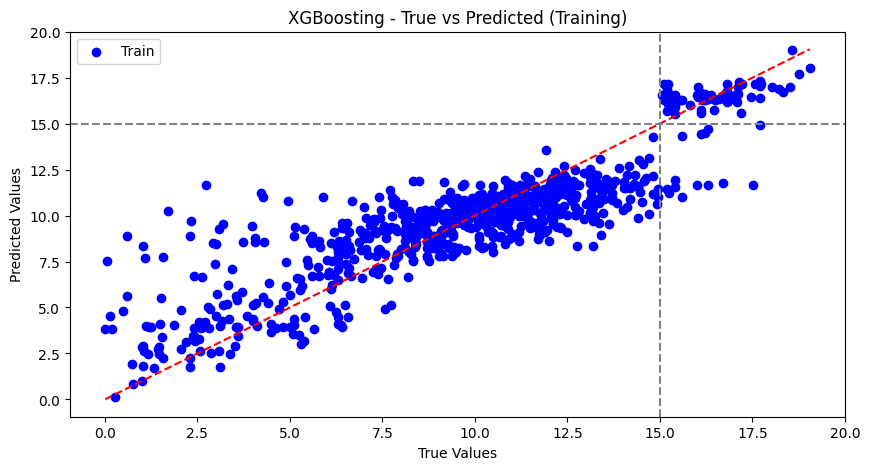

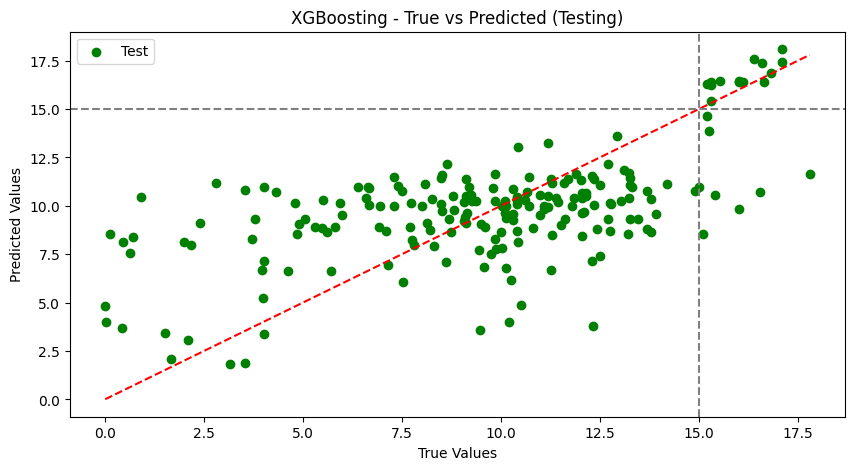

In [ ]:
threshold = 15

# Plot for training data
plt.figure(figsize=(10, 5))
plt.scatter(y_train, y_train_pred, color='blue', label='Train')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.axhline(y=threshold, color='gray', linestyle='--')  # Horizontal line at threshold
plt.axvline(x=threshold, color='gray', linestyle='--')  # Vertical line at threshold
plt.title('XGBoosting - True vs Predicted (Training)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Plot for testing data
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_test_pred, color='green', label='Test')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.axhline(y=threshold, color='gray', linestyle='--')
plt.axvline(x=threshold, color='gray', linestyle='--')
plt.title('XGBoosting - True vs Predicted (Testing)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [ ]:
X_train_filtered = X_train_scaled[y_train >= 15]
y_train_filtered = y_train[y_train >= 15]

y_train_pred_filtered = selected_xg_model.predict(X_train_filtered)

r_train_filtered = np.corrcoef(y_train_filtered, y_train_pred_filtered)[0, 1]
mape_train_filtered = mean_absolute_percentage_error(y_train_filtered, y_train_pred_filtered)
rmse_train_filtered = np.sqrt(mean_squared_error(y_train_filtered, y_train_pred_filtered))

print(f'Selected Model - Training Pearson Correlation Coefficient (r): {r_train_filtered:.4f}')
print(f'Selected Model - Training Mean Absolute Percentage Error (MAPE): {mape_train_filtered:.4f}')
print(f'Selected Model - Training Root Mean Squared Error (RMSE): {rmse_train_filtered:.4f}')


Selected Model - Training Pearson Correlation Coefficient (r): 0.3688
Selected Model - Training Mean Absolute Percentage Error (MAPE): 0.0691
Selected Model - Training Root Mean Squared Error (RMSE): 1.7116


In [ ]:
print(f"During Train : on PCE > 15 :  {len(y_train_pred_filtered[y_train_pred_filtered >=15])} found / {len(y_train_filtered)}")

During Train : on PCE > 15 :  68 found / 82


In [ ]:
X_test_filtered = X_test_scaled[y_test >+ 15]
y_test_filtered = y_test[y_test >+ 15]



y_test_pred_filtered = selected_xg_model.predict(X_test_filtered)

r_test_filtered = np.corrcoef(y_test_filtered, y_test_pred_filtered)[0, 1]
mape_test_filtered = mean_absolute_percentage_error(y_test_filtered, y_test_pred_filtered)
rmse_test_filtered = np.sqrt(mean_squared_error(y_test_filtered, y_test_pred_filtered))


print(f'Selected Model - Testing Pearson Correlation Coefficient (r): {r_test_filtered:.4f}')
print(f'Selected Model - Testing Mean Absolute Percentage Error (MAPE): {mape_test_filtered:.4f}')
print(f'Selected Model - Testing Root Mean Squared Error (RMSE): {rmse_test_filtered:.4f}')

Selected Model - Testing Pearson Correlation Coefficient (r): 0.1937
Selected Model - Testing Mean Absolute Percentage Error (MAPE): 0.1193
Selected Model - Testing Root Mean Squared Error (RMSE): 2.9711


In [ ]:
print(f"During Test : on PCE > 15 :  {len(y_test_pred_filtered[y_test_pred_filtered >=15])} found / {len(y_test_filtered)}")

During Test : on PCE > 15 :  14 found / 21


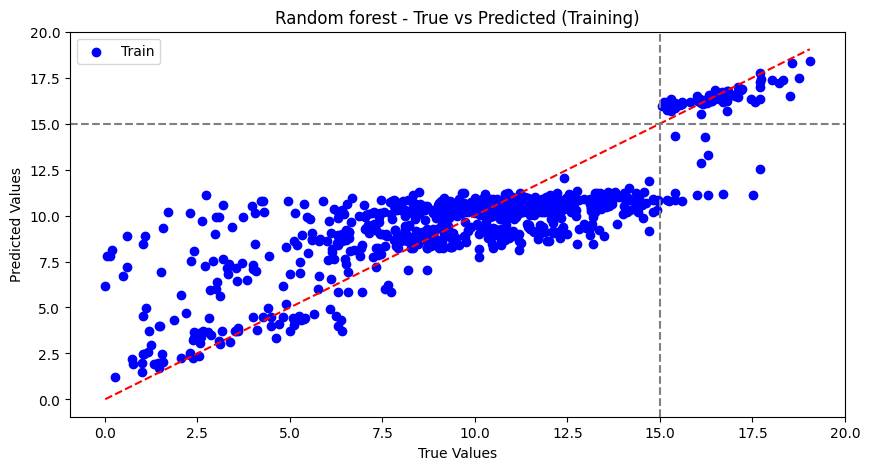

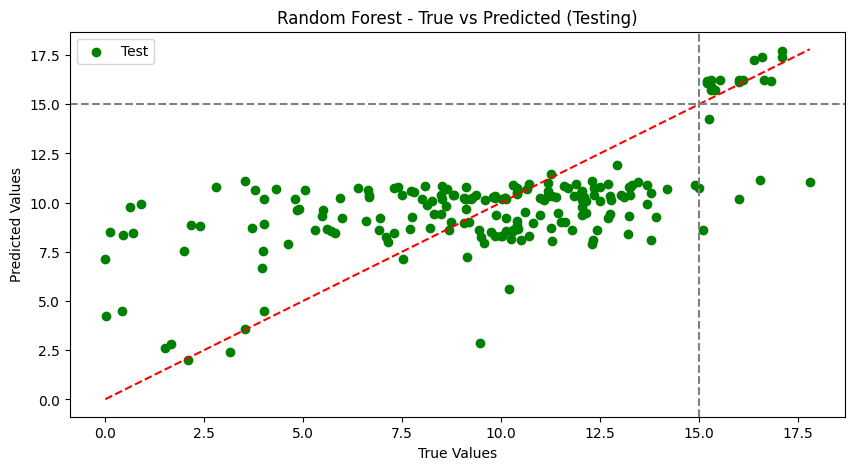

In [ ]:
best_params = {'max_depth': 7, 'n_estimators': 200}
selected_rf_model = RandomForestRegressor(**best_params)

selected_rf_model.fit(X_train_scaled, y_train)
y_train_pred = selected_rf_model.predict(X_train_scaled)
y_test_pred = selected_rf_model.predict(X_test_scaled)

threshold = 15

# Plot for training data
plt.figure(figsize=(10, 5))
plt.scatter(y_train, y_train_pred, color='blue', label='Train')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.axhline(y=threshold, color='gray', linestyle='--')  # Horizontal line at threshold
plt.axvline(x=threshold, color='gray', linestyle='--')  # Vertical line at threshold
plt.title('Random forest - True vs Predicted (Training)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Plot for testing data
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_test_pred, color='green', label='Test')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.axhline(y=threshold, color='gray', linestyle='--')  # Horizontal line at threshold
plt.axvline(x=threshold, color='gray', linestyle='--')  # Vertical line at threshold
plt.title('Random Forest - True vs Predicted (Testing)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [ ]:
X_train_filtered = X_train_scaled[y_train >= 15]
y_train_filtered = y_train[y_train >= 15]

y_train_pred_filtered = selected_rf_model.predict(X_train_filtered)

r_train_filtered = np.corrcoef(y_train_filtered, y_train_pred_filtered)[0, 1]
mape_train_filtered = mean_absolute_percentage_error(y_train_filtered, y_train_pred_filtered)
rmse_train_filtered = np.sqrt(mean_squared_error(y_train_filtered, y_train_pred_filtered))

print(f'Selected Model - Training Pearson Correlation Coefficient (r): {r_train_filtered:.4f}')
print(f'Selected Model - Training Mean Absolute Percentage Error (MAPE): {mape_train_filtered:.4f}')
print(f'Selected Model - Training Root Mean Squared Error (RMSE): {rmse_train_filtered:.4f}')


Selected Model - Training Pearson Correlation Coefficient (r): 0.3900
Selected Model - Training Mean Absolute Percentage Error (MAPE): 0.0700
Selected Model - Training Root Mean Squared Error (RMSE): 1.9160


In [ ]:
print(f"During Train : on PCE > 15 :  {len(y_train_pred_filtered[y_train_pred_filtered >=15])} found / {len(y_train_filtered)}")

During Train : on PCE > 15 :  68 found / 82


In [ ]:
X_test_filtered = X_test_scaled[y_test >+ 15]
y_test_filtered = y_test[y_test >+ 15]



y_test_pred_filtered = selected_rf_model.predict(X_test_filtered)

r_test_filtered = np.corrcoef(y_test_filtered, y_test_pred_filtered)[0, 1]
mape_test_filtered = mean_absolute_percentage_error(y_test_filtered, y_test_pred_filtered)
rmse_test_filtered = np.sqrt(mean_squared_error(y_test_filtered, y_test_pred_filtered))


print(f'Selected Model - Testing Pearson Correlation Coefficient (r): {r_test_filtered:.4f}')
print(f'Selected Model - Testing Mean Absolute Percentage Error (MAPE): {mape_test_filtered:.4f}')
print(f'Selected Model - Testing Root Mean Squared Error (RMSE): {rmse_test_filtered:.4f}')

Selected Model - Testing Pearson Correlation Coefficient (r): 0.0511
Selected Model - Testing Mean Absolute Percentage Error (MAPE): 0.1011
Selected Model - Testing Root Mean Squared Error (RMSE): 2.7418


In [ ]:
print(f"{len(y_test_pred_filtered[y_test_pred_filtered >=15])} / {len(y_test_filtered)}")

16 / 21




# RESULTS ANALYSIS AND CONCLUSION OF STUDY 2

Let's analyze based on these factors:

XGBRegressor model demonstrates the best performance on the training dataset in terms of all metrics. However, it slightly underperforms on the testing dataset compared to RandomForestRegressor, which has a similar performance on the training set but slightly better performance on the testing set.


The **additional analysis** for the ability to identify **high PCE** is slightly better for the random forest because more data with high PCE have been identified, but this is based on a difference of 2 combinations, which is not enough to make a decision.

Considering these factors, **RandomForestRegressor** appears to be the best choice in this scenario, offering a good balance between performance, robustness, and interpretability. However, if computational resources allow and interpretability is not a concern, **XGBRegressor** could also be a viable option.

**But we recommend ongoing testing as new label data become available.**


### Feature importance

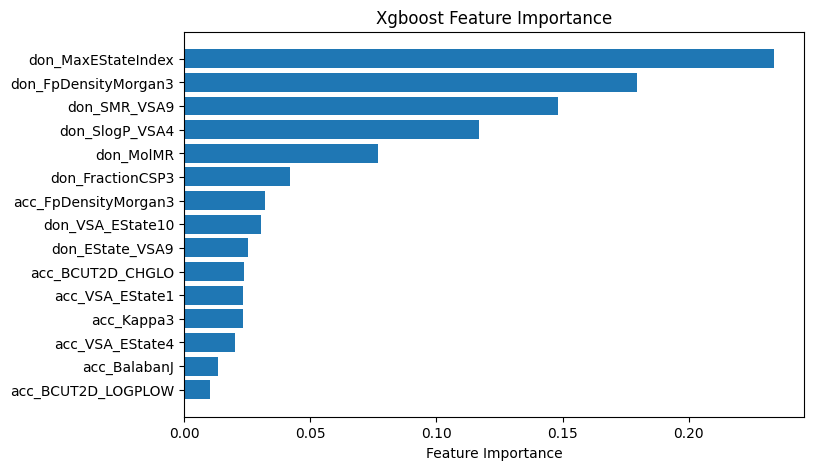

In [ ]:
new_xg_feature_importance = selected_xg_model.feature_importances_


# Plot Feature Importance
plt.figure(figsize=(8, 5))
sorted_indices_xg = np.argsort(new_xg_feature_importance)
plt.barh(range(len(X_train.columns)), new_xg_feature_importance[sorted_indices_xg], align="center")
plt.yticks(range(len(X_train.columns)), X_train.columns[sorted_indices_xg])
plt.xlabel("Feature Importance")
plt.title("Xgboost Feature Importance")
plt.show()

# COMPARISON OF 2 STUDIES